In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from gensim.models import LdaModel, CoherenceModel
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [3]:
file = pd.read_table('../steps/discretized_9.features', dtype=str)
df = file.drop(['Sample', 'Chr'], axis = 1)
listedDf = df.values.tolist()
dirichlet_dict = corpora.Dictionary(listedDf)
bow_corpus = [dirichlet_dict.doc2bow(text) for text in listedDf]

## Using 2-15 topics

In [4]:
# Considering 1-15 topics, as the last is cut off
num_topics = list(range(16)[1:])
num_keywords = 3

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = LdaModel.load(f'../steps/gensim/lda_t{i}_f10.model')

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [5]:
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [6]:
coherences = [CoherenceModel(model=LDA_models[i], corpus=bow_corpus, texts = listedDf, dictionary=dirichlet_dict, coherence='c_v', topn = 3).get_coherence() for i in num_topics[:-1]]

In [7]:
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

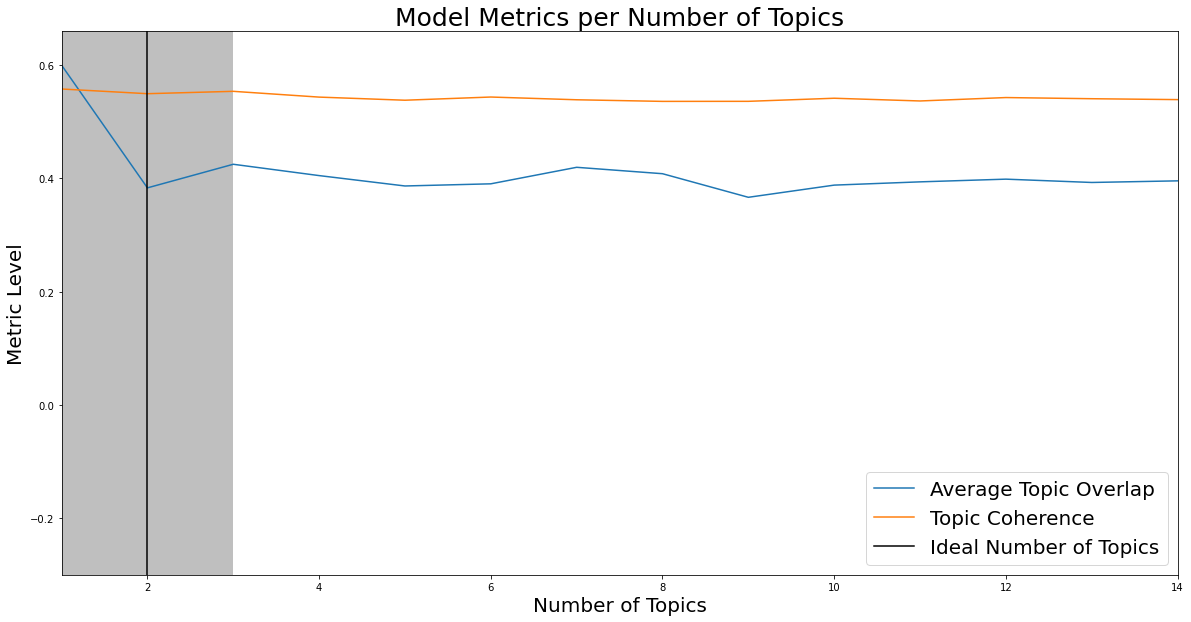

In [8]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([-0.3, y_max])
# ax.set_ylim([-0.3, -0.2])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()   

In [9]:
gensimvis.prepare(LDA_models[13], bow_corpus, dirichlet_dict)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.095533  0.007210       1        1  11.256557
11     0.082868  0.075478       2        1   9.574444
4     -0.091947 -0.088692       3        1   9.244864
0     -0.068547  0.087812       4        1   8.704291
7      0.096088 -0.023326       5        1   8.308982
8      0.051050 -0.098409       6        1   8.121816
3      0.053014  0.021232       7        1   7.842333
2     -0.003802  0.008195       8        1   7.687854
9      0.004433  0.005612       9        1   6.962587
6      0.011257 -0.028704      10        1   6.912860
10     0.023020  0.016982      11        1   6.673133
12    -0.051021  0.035943      12        1   4.363016
5     -0.010880 -0.019332      13        1   4.347261, topic_info=   Term           Freq          Total Category  logprob  loglift
5     6  261426.000000  261426.000000  Default   7.0000   7.0000
4     4  326952.000000  326952.000000  Default   6.0000   6.0000
6     5  363929.000000  363929.000000  Default   5.0000   5.0000
1     1  344362.000000  344362.000000  Default   4.0000   4.0000
2     2  400519.000000  400519.000000  Default   3.0000   3.0000
..  ...            ...            ...      ...      ...      ...
0     0   10661.463766  210147.671478  Topic13  -2.2226   0.1544
2     2   19256.701798  400519.648326  Topic13  -1.6314   0.1007
3     3    9334.397871  356620.403067  Topic13  -2.3555  -0.5073
4     4    6205.796692  326952.275372  Topic13  -2.7638  -0.8287
1     1    5819.983617  344362.998084  Topic13  -2.8279  -0.9448

[98 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.123342    0
0         2  0.113649    0
0         3  0.071949    0
0         4  0.092145    0
0         5  0.098459    0
...     ...       ...  ...
5         9  0.041186    6
5        10  0.052730    6
5        11  0.013939    6
5        12  0.065984    6
5        13  0.095074    6

[91 rows x 3 columns], R=7, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 12, 5, 1, 8, 9, 4, 3, 10, 7, 11, 13, 6])

In [10]:
gensimvis.prepare(LDA_models[7], bow_corpus, dirichlet_dict)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.069554  0.055438       1        1  23.497850
3      0.094084  0.001904       2        1  15.458478
6      0.030160 -0.034630       3        1  14.844988
2     -0.001176 -0.027554       4        1  13.060571
0      0.018814  0.080809       5        1  12.742715
4     -0.081527 -0.042627       6        1  10.950291
5      0.009200 -0.033340       7        1   9.445108, topic_info=  Term           Freq          Total Category  logprob  loglift
1    1  345726.000000  345726.000000  Default   7.0000   7.0000
6    5  361498.000000  361498.000000  Default   6.0000   6.0000
4    4  326905.000000  326905.000000  Default   5.0000   5.0000
5    6  264439.000000  264439.000000  Default   4.0000   4.0000
2    2  399795.000000  399795.000000  Default   3.0000   3.0000
3    3  355049.000000  355049.000000  Default   2.0000   2.0000
0    0  210543.000000  210543.000000  Default   1.0000   1.0000
5    6  144405.796364  264439.799806   Topic1  -1.3040   0.8433
1    1  129849.956032  345726.669401   Topic1  -1.4102   0.4690
0    0   53917.454823  210543.231175   Topic1  -2.2892   0.0860
3    3   74272.200230  355049.743766   Topic1  -1.9689  -0.1163
4    4   56102.580394  326905.319922   Topic1  -2.2494  -0.3142
2    2   44926.078205  399795.765849   Topic1  -2.4716  -0.7377
6    5   28507.683706  361498.672246   Topic1  -2.9264  -1.0918
2    2  133538.924132  399795.765849   Topic2  -0.9635   0.7705
0    0   38328.740866  210543.231175   Topic2  -2.2117   0.1635
6    5   53452.993631  361498.672246   Topic2  -1.8791  -0.0444
4    4   48321.905629  326905.319922   Topic2  -1.9800  -0.0448
3    3   52227.157840  355049.743766   Topic2  -1.9023  -0.0496
5    6   23122.654114  264439.799806   Topic2  -2.7170  -0.5698
1    1     981.237818  345726.669401   Topic2  -5.8768  -3.9976
3    3  125877.803958  355049.743766   Topic3  -0.9821   0.8706
0    0   36514.879728  210543.231175   Topic3  -2.2196   0.1555
6    5   62374.464846  361498.672246   Topic3  -1.6842   0.1504
2    2   49610.851862  399795.765849   Topic3  -1.9132  -0.1792
4    4   23914.774525  326905.319922   Topic3  -2.6429  -0.7077
5    6   16818.753936  264439.799806   Topic3  -2.9949  -0.8476
1    1   20972.951587  345726.669401   Topic3  -2.7741  -0.8949
4    4   72727.114993  326905.319922   Topic4  -1.4026   0.5326
6    5   77128.504774  361498.672246   Topic4  -1.3438   0.4908
1    1   51979.630845  345726.669401   Topic4  -1.7384   0.1408
0    0   26071.204248  210543.231175   Topic4  -2.4285  -0.0533
3    3   37644.292532  355049.743766   Topic4  -2.0611  -0.2085
2    2   30120.042769  399795.765849   Topic4  -2.2841  -0.5502
5    6      15.196777  264439.799806   Topic4  -9.8760  -7.7287
4    4  103553.249725  326905.319922   Topic5  -1.0246   0.9106
5    6   37310.894263  264439.799806   Topic5  -2.0454   0.1019
2    2   54823.195502  399795.765849   Topic5  -1.6605   0.0734
0    0   26905.814158  210543.231175   Topic5  -2.3723   0.0029
1    1   27121.843454  345726.669401   Topic5  -2.3643  -0.4851
3    3   22507.056084  355049.743766   Topic5  -2.5508  -0.6982
6    5   16267.815713  361498.672246   Topic5  -2.8755  -1.0409
1    1   98513.555278  345726.669401   Topic6  -0.9229   0.9563
2    2   51723.238633  399795.765849   Topic6  -1.5672   0.1668
6    5   43657.771136  361498.672246   Topic6  -1.7367   0.0979
3    3   24447.744962  355049.743766   Topic6  -2.3165  -0.4639
5    6   14087.690420  264439.799806   Topic6  -2.8678  -0.7205
4    4    9861.946651  326905.319922   Topic6  -3.2244  -1.2892
0    0    5618.164818  210543.231175   Topic6  -3.7871  -1.4119
6    5   80109.438441  361498.672246   Topic7  -0.9818   0.8528
0    0   23186.972534  210543.231175   Topic7  -2.2216   0.1536
5    6   28678.813932  264439.799806   Topic7  -2.0090   0.1382
2    2   35053.434746  399795.765849   Topic7  -1.8083  -0.0744
3    3   18073.

In [11]:
gensimvis.prepare(LDA_models[4], bow_corpus, dirichlet_dict)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.055280  0.032441       1        1  30.197917
1      0.079463 -0.014377       2        1  27.897693
2     -0.038696 -0.060102       3        1  24.137805
0      0.014513  0.042038       4        1  17.766585, topic_info=  Term           Freq          Total Category  logprob  loglift
4    4  327091.000000  327091.000000  Default   7.0000   7.0000
5    6  264850.000000  264850.000000  Default   6.0000   6.0000
1    1  351154.000000  351154.000000  Default   5.0000   5.0000
6    5  360946.000000  360946.000000  Default   4.0000   4.0000
2    2  396943.000000  396943.000000  Default   3.0000   3.0000
3    3  353393.000000  353393.000000  Default   2.0000   2.0000
0    0  209578.000000  209578.000000  Default   1.0000   1.0000
3    3  165376.587360  353393.914061   Topic1  -1.4192   0.4380
2    2  182015.266927  396943.616991   Topic1  -1.3234   0.4177
6    5  133637.146652  360946.199370   Topic1  -1.6323   0.2038
0    0   75289.792767  209578.818369   Topic1  -2.2061   0.1736
4    4   64957.722797  327091.071232   Topic1  -2.3537  -0.4191
5    6   50226.384205  264850.715398   Topic1  -2.6109  -0.4652
1    1   12165.577373  351154.703883   Topic1  -4.0289  -2.1652
5    6  170233.155733  264850.715398   Topic2  -1.3111   0.8346
1    1  166692.960077  351154.703883   Topic2  -1.3321   0.5316
0    0   59156.197141  209578.818369   Topic2  -2.3681   0.0117
3    3   89474.459917  353393.914061   Topic2  -1.9543  -0.0970
4    4   50716.188793  327091.071232   Topic2  -2.5220  -0.5874
2    2   51408.015744  396943.616991   Topic2  -2.5085  -0.7674
6    5   43911.402651  360946.199370   Topic2  -2.6661  -0.8299
6    5  153820.677067  360946.199370   Topic3  -1.2677   0.5684
1    1  133009.287909  351154.703883   Topic3  -1.4131   0.4506
4    4   69911.438445  327091.071232   Topic3  -2.0563  -0.1216
2    2   80706.866946  396943.616991   Topic3  -1.9127  -0.1716
3    3   71106.852649  353393.914061   Topic3  -2.0393  -0.1820
0    0   36876.291280  209578.818369   Topic3  -2.6959  -0.3161
5    6    1038.624722  264850.715398   Topic3  -6.2656  -4.1199
4    4  141505.721197  327091.071232   Topic4  -1.0447   0.8900
2    2   82813.467373  396943.616991   Topic4  -1.5804   0.1606
0    0   38256.537181  209578.818369   Topic4  -2.3527   0.0271
5    6   43352.550738  264850.715398   Topic4  -2.2277  -0.0820
1    1   39286.878523  351154.703883   Topic4  -2.3261  -0.4625
6    5   29576.973000  360946.199370   Topic4  -2.6100  -0.7739
3    3   27436.014135  353393.914061   Topic4  -2.6852  -0.8279, token_table=      Topic      Freq Term
term                      
0         1  0.359244    0
0         2  0.282261    0
0         3  0.175953    0
0         4  0.182542    0
1         1  0.034646    1
1         2  0.474700    1
1         3  0.378776    1
1         4  0.111879    1
2         1  0.458541    2
2         2  0.129510    2
2         3  0.203321    2
2         4  0.208627    2
3         1  0.467968    3
3         2  0.253185    3
3         3  0.201212    3
3         4  0.077636    3
4         1  0.198593    4
4         2  0.155052    4
4         3  0.213736    4
4         4  0.432620    4
6         1  0.370241    5
6         2  0.121655    5
6         3  0.426160    5
6         4  0.081943    5
5         1  0.189639    6
5         2  0.642751    6
5         3  0.003923    6
5         4  0.163688    6, R=7, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

In [12]:
gensimvis.prepare(LDA_models[2], bow_corpus, dirichlet_dict)

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.119041  0.0       1        1  68.047602
1     -0.119041  0.0       2        1  31.952398, topic_info=  Term           Freq          Total Category  logprob  loglift
1    1  348049.000000  348049.000000  Default   7.0000   7.0000
5    6  264107.000000  264107.000000  Default   6.0000   6.0000
2    2  398918.000000  398918.000000  Default   5.0000   5.0000
4    4  327394.000000  327394.000000  Default   4.0000   4.0000
0    0  209937.000000  209937.000000  Default   3.0000   3.0000
3    3  354476.000000  354476.000000  Default   2.0000   2.0000
6    5  361075.000000  361075.000000  Default   1.0000   1.0000
2    2  381429.580701  398918.376538   Topic1  -1.3960   0.3401
4    4  288112.442088  327394.714310   Topic1  -1.6766   0.2571
3    3  301334.754067  354476.609998   Topic1  -1.6317   0.2225
6    5  291735.448038  361075.379052   Topic1  -1.6641   0.1717
0    0  161938.772553  209937.687243   Topic1  -2.2527   0.1254
1    1   67087.333779  348049.081775   Topic1  -3.1339  -1.2614
5    6   48931.447588  264107.104867   Topic1  -3.4495  -1.3010
5    6  215175.657279  264107.104867   Topic2  -1.2125   0.9360
1    1  280961.747997  348049.081775   Topic2  -0.9457   0.9268
0    0   47998.914691  209937.687243   Topic2  -2.7128  -0.3347
6    5   69339.931014  361075.379052   Topic2  -2.3449  -0.5091
3    3   53141.855931  354476.609998   Topic2  -2.6110  -0.7568
4    4   39282.272223  327394.714310   Topic2  -2.9132  -0.9795
2    2   17488.795837  398918.376538   Topic2  -3.7224  -1.9863, token_table=      Topic      Freq Term
term                      
0         1  0.771367    0
0         2  0.228635    0
1         1  0.192752    1
1         2  0.807248    1
2         1  0.956161    2
2         2  0.043841    2
3         1  0.850084    3
3         2  0.149917    3
4         1  0.880014    4
4         2  0.119984    4
6         1  0.807961    5
6         2  0.192037    5
5         1  0.185270    6
5         2  0.814730    6, R=7, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])